# Question

<img src="Superbikes-lineup.jpg">

I have previously owned a motorbike, [Suzuki Across], when i was younger. I was forced to sell the bike due to the fact that I couldn't afford to own a car and a bike at the same time. This has now changed, my career has progressed and I am approaching "mid-life", so its a perfect to go through my "mid life crisis" and buy a motorbike 😉.

The motovation for the purchase is purely enjoyment, and will not neccessarily be used for commuting. This means that emotion can easily get in the way of paying a reasonable price for the bike. So I would like to remove the "emotional" choices from this decision as much as possible.

It is commonly accepted that a used car's sale price is related to a few [features]; The age, Model, Condition, and kilomters on the odmeter. *Is this the same for motorbikes?*

There may be a cause to say that bikes could be considered differntly as they are predominantly used for enjoyment and not commuting to and from work or down to the shops. Additionally the smaller [learner legal] bikes may retain more value because all new riders are restricted to these types of bikes.

Some questions to ask of the data.

- What features are able to predict the price of a motorbike?
- How much can I save if I buy an older bike?
- How much can I save if there are more kilometers? and how many more kilometers does it take?
- How does the model of the bike affect the sale price?
- Does the location affect the sale price?
- What is the most popular make and model?


[Suzuki Across]:(https://en.wikipedia.org/wiki/Suzuki_Across)
[features]:(https://help.carsales.com.au/hc/en-gb/articles/360015482932-Price-Indicators)
[learner legal]:(https://www.rms.nsw.gov.au/roads/licence/rider/approved-novice-motorcycles.html)

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')


In [245]:
file = 'BikeSalesData.csv'

df = pd.read_csv(file, 
                 parse_dates=['First_Seen','Last_Seen','Last Modified'], 
                 infer_datetime_format=True, 
                 na_values='-')


## EDA
1. Examine what features are available in the data set.
2. Privide meaningfull definitions of each feature.
3. Determine the different data types
4. Find the features that have missing values, and develop a solution.
    1. Remove the feature all together    
    2. Use Domain knowldge to fill in missing values.
    3. Fill the missing values using statistical techniques (mean, mode, ...)

In [246]:
list(df.columns)

['Unnamed: 0',
 '1st Gear Ratio',
 '2nd Gear Ratio',
 '3rd Gear Ratio',
 '4th Gear Ratio',
 '5th Gear Ratio',
 '6th Gear Ratio',
 'ABS',
 'ABS Selectable',
 'Acceleration',
 'Adjustable Front Footrests',
 'Adjustable Rear Footrests',
 'Adjustable Seat',
 'Airbag(s)',
 'Alarm',
 'Australian Capital Territory',
 'Backrest - Pillion',
 'Backrest - Rider',
 'Battery Description',
 'Bike',
 'Bluetooth',
 'Body',
 'Bore',
 'CB Radio',
 'CD Player',
 'Cam Type',
 'Carburettor',
 'Carburettor(s)',
 'Charge Time (hrs)',
 'Charging Method',
 'Chassis Description',
 'Clutch Diameter',
 'Clutch Type',
 'Colour',
 'Compression Ratio',
 'Configuration',
 'Coolant Capacity',
 'Cooling',
 'Country of Origin',
 'Crash Bar',
 'Cruise Control',
 'Cup Holders',
 'Cylinders',
 'Decibel Rating',
 'Descent Control',
 'Description',
 'Drive Type',
 'Driven Wheels',
 'Driver Restraint',
 'Dry Weight',
 'Dual Front Wheels',
 'Economy Mode',
 'Electronic Power Steering',
 'Electronic Suspension Adjustment',
 'Em

In [247]:
df.head()

,Unnamed: 0,1st Gear Ratio,2nd Gear Ratio,3rd Gear Ratio,4th Gear Ratio,5th Gear Ratio,6th Gear Ratio,ABS,ABS Selectable,Acceleration,...,Wheel Size Front,Wheel Size Rear,Wheel Type,Wheelbase,Width,Width Including Mirrors,Winch,Windscreen,Windscreen Type,iPOD Connectivity
0,0,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,"1.60x21""","1.85x18""","Chrome rim, Heavy duty Spokes, Alloy Hub",1480 mm,860 mm,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,"2.75x17""","3.5x17""","Black, T9 Aluminium rims, 5-star spoke",1350 mm,NaN,NaN,NaN,Standard,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Observations of the data so far
1. There are a number of features `Unnamed:...` that would appear to be irrelavant and may be a by-product of the scraping process, so we can likely remove these straight away.
2. There are features that will need processing to convert the value into something meaningfull, ie. removing the units from various features.
3. There are some possible duplications of features that may require combination (ie. Carburettor and Carburettor(s) )

### Definitions

`Unnamed: 0`: Index value when written to file

`Unnamed: 1`: Empty feature that seems to be a by-product of the scraping process.

`1st Gear Ratio`: The ratio of teeth between the front and rear sockets for 1st gear.

`2nd Gear Ratio`: The ratio of teeth between the front and rear sockets for 2nd gear.

`3rd Gear Ratio`: The ratio of teeth between the front and rear sockets for 3rd gear.

`4th Gear Ratio`: The ratio of teeth between the front and rear sockets for 4th gear.

`5th Gear Ratio`: The ratio of teeth between the front and rear sockets for 5th gear.

`6th Gear Ratio`: The ratio of teeth between the front and rear sockets for 6th gear.

`ABS`: Anti-Lock Breaking System, which stops the breaks from locking.

`ABS Selectable`: Ability to turn the vehicle ABS on and off

`Acceleration`: The time it takes for the vehicle to reack 100 km/h

`Adjustable Front Footrests`: Indicates if the front foot rests can be adjusted for a riders height

`Adjustable Seat`: Indicates if the seat has an adjsutable height

`Airbag(s)`: Indicates if there are air bags fitted to the vehicle

`Alarm`: Indicates if an alarm is an optional extra or already fitted to the vehicle.

`Australian Capital Territory`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Backrest - Pillion`: Indicates if a backrest is available for a pillion rider.

`Backrest - Rider`: Indicates if a backrest is available for the main rider.

`Battery Description`: Description of the Battery, typically indicating the battery type and ampage.

`Bike`: Description of the vehicle, typically the make and model.

`Bluetooth`: Indicates if bluetooth is available as standard.

`Body`: A description of the body type, ie, sports, touring, scooter, etc ...

`Bore`: The Bore indicates the diamater of the bore cyclinder of the engine.

`CD Player`: Indicates if a CD player is available as standard on the vehicle.

`Cam Type`: Description of the engine cam type.

`Carburettor`: Typically describes the carburettor type, but can also represent the number of carburettors on the vehicle.

`Carburettor(s)`: The number of carburettors.

`Charge Time (hrs)`: Time to recharge the battery, typically only relevant for electric motors.

`Charging Method`: The method of charging the engine.

`Chassis Description`: Description of the motorvehicle chassis.

`Clutch Diameter`: The diameter of the clutch plate.

`Clutch Type`: Description of the clutch type.

`Colour`: Main colour of the vehicle

`Compression Ratio`: The proportional ratio of volume inside the combustion chamber from its largest to smallest capacity.

`Configuration`: The configuration of teh engine of the vehicle,

`Coolant Capacity`: Capacity of liquid coollant required.

`Cooling`: Cooling system on the vehicle.

`Country of Origin`: Country of manufacture.

`Crash Bar`: Indicates if a crash bar is fitted, preventing the vehicle from damaging the chassis if dropped.

`Cruise Control`: Indicates if cruise control is fitted to the vehicle

`Cup Holders`: Indicates if cup holders are fitted to the vehicle.

`Cylinders`: The number of cyclinders in the engine.

`Decibel Rating`: ???

`Descent Control`: Indicates if the vehicle has descent control as standard.

`Description`: Detailed description of the condition and extras by the owner.

`Drive Type`: Describes the type fo drive system.

`Driven Wheels`: The number of wheels that are driven by the drive system.

`Driver Restraint`: Indicates if a driver restraint is fitted for safety, this is typically only available on 4 wheel drive vehicles

`Dry Weight`: The weight of the vehicle when no petrol or oil has been added.

`Dual Front Wheels`: ???

`Economy Mode`: Identifies if the vehicle has an economy mode, typically associated with electric vehicles.

`Electronic Power Steering`: Identifies if the vehile has power steering, this is typically associated with 4 wheel vehicles.

`Electronic Suspension Adjustment`: Identifies if the vehicle has electronically controlled adjustable suspension.

`Emission Standard`: Specifies the [European emission standards] acceptable for exhaust emissions of a vehicles sold in the European Union and EEA member states. the standard is generally specific to the year of manufacture, with newer vehicles subject to stricter standards.

`Engine Braking System`: Identifies if the vehicle has a automatic engine cuttoff.

`Engine Capacity`: The size of the engine in cubic centimetres.

`Engine Config`: Description of the engine configuration.

`Engine Description`: Description of the engine size, typically the same as the engine capacity.

`Engine Immobiliser`: Identifies if there is an engine imobiliser installe

`Engine Stroke`: The number of pistons the engine has.

`Engine Type`: The description of the engine type

`Engine Voltage`: The Voltage generated by the Engine

`Exhaust Config`: The configuration of the exhaust system

`Exhaust Description`: Description of the muffler materials.

`Final Drive Ratio`: The ratio of teeth between the 1st and 6th (last) gear .

`First Service Interval`: The km at which the manufacture recomends the first service take place.

`First_Seen`: The date the advertisement was first seen.

`Frame Design`: The design of the frame structure.

`Frame Material`: The materials used in the frame.

`Front Brake Caliper(s)`: Description of the front brakes callipers.

`Front Brake Description`: Description of the front brakes.

`Front Brake Diameter`: The size of the front brake disc.

`Front Differential Lock`: Identifies if the vehicle has a differential lock system on the front wheels, typically associated with 4 wheeled vehicles.

`Front Payload / Carry Weight`: The payload weight permitted to carry on the front 

`Front Receiver`:  ???

`Front Suspension`: Description of the front sussension system

`Front Suspension Travel`: The distance the suspension will travel at full compression.

`Front Tyre`: Description of the front tyre.

`Fuel Reserve Capacity`: Capacity of the reserve tank.

`Fuel Tank Capacity`: Capacity of the fuel tank.

`Fuel Type`: Type of fuel required.

`GPS Navigation`: Identifies if GPS navigation is available.

`Gear Change Method`: The method to change gears.

`Gear Number`: The number of gears, exluding neutral.

`Gear Type`: Description of the transmission.

`Glove Box(s)`: Identifies if the vehicle has a glov box, typically associated with four wheeled vehicles.

`Ground Clearance`: The distance between the ground and the base of the vehicle frame.

`Handlebar Description`: Description of the handlebars.

`Hands Free Ignition`: Identifies if teh vehicle has hands free ignition.

`Heated Hand Grips`: Identifies if heated hand grips are available.

`Heated Seats`: Identifies if a heated seat is available.

`Height`: The height of the vehicle from the ground to the talles point, excluding the windscreen.

`Height Including Windscreen`: The height of the vehicle from the ground to the top of the windscreen.

`Ignition`: Type of ignition system.

`Ignition Description`: Description of the ignition system.

`Induction System`: Type of induction system used.

`Instruments / Dash Description`: List of instruments available on the dash board.

`KM Range (Full Charge)`: Expected travel distance on a full charge, typically only applies to electric vehicles.

`KM Range (Full Tank)`: Expected travel distance on a full tank.

`Kilometers`: The distance the vehicle has previously travelled.

`Last Modified`: The last date the advertisement was modified.

`Last_Seen`: The last date the advertisement was seen.

`Launch Control`: Identifies if electronic launch control is available.

`Learner Approved`: Identifies if the vehicle is learner legal

`Length`: The length of the vehicle.

`Linked Braking System`: Identifies if the front and rear brakes are linked, and the type of linking.

`Lock Type`: The locking system used on the vehicle.

`Lubrication`: A description of the lubrication system.

`MP3 Capatible`: Identifies if MP3 compatibility is available.

`Max Ethanol Blend`: Specifies the maximum ethenol fuel blend acceptable.

`Maximum Power`: Maximum power in kilowatts available to the tyres.

`Maximum Power RPM`: Maximum engine revolutions per minute.

`Maximum Speed`: Maximum speed achievable by the vehicle.

`Maximum Torque`: Maximum torque in Newton metres, on the wheels.

`Maximum Torque RPM`: Maximum tyre revolutions per minute

`Nerf Bars`: Identifies if a Nerf bar is available.

`Network ID`: An identification code for the advertisement. *This should be a unique identifier*

`New South Wales`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Northern Territory`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Number of Throttle Bodies`: Number of cylinders in the throttle assembly.

`Oil Capacity`: Volume capacity of engine oil.

`Park Brake`: Identifies if a park brake is available.

`Passenger(s) Restraint`: Identifies if a passenger restraint is available, typically only associated with four wheeled vehicles.

`Payload / Carry Weight`: Maximum payload permissible for the vehicle.

`Payment`: Description of secure payment method.

`Postcode`: Postcode the vehicle is kept.

`Price`: The listed price of the vehicle.

`Primary Drive`: Description of teh primary drive system.

`Queensland`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Quick Shift`: Identifies if a quick shift is available.

`ROPS Approved`: Identifies if an approved Rollover Protection Structure (ROPS) is fitted, typically only available on four wheeled vehicles.

`Rake (Caster Angle)`: The angle from the vertical axis of the front suspension arm of the vehicle.

`Rear Brake Caliper(s)`: Description of the rear brakes callipers

`Rear Brake Description`: Description of the rear brakes.

`Rear Brake Diameter`: The size of the rear brake disc.

`Rear Cargo Bed Depth`: The depth of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Cargo Bed Length`: The length of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Cargo Bed Width`: The width of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Differential Lock`: Identifies if the vehicle has a differential lock system on the rear wheels, typically associated with 4 wheeled vehicles.

`Rear Payload / Carry Weight`: The payload weight permitted to carry on the rear. 

`Rear Receiver`: ???

`Rear Suspension`: Description of the rear suspension.

`Rear Suspension Travel`: The distance the suspension will travel at full compression.

`Rear Tyre`: Description of the rear tyre.

`Recommended RON`: Recomended fuel ocatane number.

`Registration Expiry`: Date the registration expires.

`Registration Plate`: Registration identification.

`Registration Status`: The status of the registration.

`Regular Service Interval`: Recomended regular service interval in km.

`Release Date`: Date the vehicle was first released.

`Reverse Gear`: Identifies if the vehicle has reverse gear, typically associated with four wheeled vehicles.

`Ride By Wire`: Identifies if ride-by-wire is available (*The absence of mechanical linkage between accelerator and throttle*)

`Rider / Pillion Communication`: Identifies if internal communication between rider and pillion is available.

`Roadside Assistance`: Identifies if roadside assistance is available.

`Roadworthy/Safety Certificate`: Specifies if a roadworthy certificate is available.

`Roof`: Specifies if the vehicle has a roof available.

`Saddlebags/Panniers`: Identifies if panniers are available.

`Safety Cut Off Cord`: Identifies if a safety cut off cord is available.

`Seat Description`: Description of the seat characteristics.

`Seat Height`: The height of the seat from the ground.

`Seat Height Max`: The maximum seat height from the ground.

`Seating Capacity`: The standard capacity of the vehicles.

`Seating Position`: Description of the seating position.

`Side Stand`: Identifies if a side stand is available.

`Side Stand Start Inhibitor`: Identifies if a side stand inhibitor is available.

`Skid Plate`: Identifies if a skid plate is available

`Snorkel Air Intake`: Identifies if a snorkel is avalable.

`South Australia`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Spark Plug Description`: Description of the spark plugs fitted.

`Stability Control`: Identifies if stability control is available.

`Starter`: Description of the starter motor.

`State`: The state in which the vehicle is location.

`Steering Damper`: Identifies if a steering damper is available.

`Stock Number`: Stock identification used for dealers.

`Stroke`: The distance a stroke moves in the engine cylinders.

`Suburb`: The suburb the vehicle is kept.

`Swingarm Description`: Description of the swingarm.

`Swingarm Type`: Description of teh type of swingarm.

`Tasmania`:  Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Throttle Bore`: Diametre and description of the throttle cyclinders in the throttle assembly.

`Tilt Steering`: Identifies if tilt steering is available, typically associated with three wheeled vehicles.

`Tool Kit`: Identifies if a tool kit is available.

`Top Box`: Identifies if a top box, sometimes refered to as a helmet box, is available.

`Towing Capability`: Identifies if the vehicle is capable of towing.

`Traction Control`: Identifies if traction control is available.

`Traction Control Selectable`: Identifies if traction control can be tunred on and off.

`Trail`: ??

`Trailer Payload`: The maximum payload allowable on the trailer.

`Transmission Description`: Description of the transmission

`Turning Radius`: The radius of the turning circle of the vehicle.

`Tyre Pressure Sensors`: Identifies if a tyre pressure sensor is available.

`URL`: The URL of the advertisement.

`USB Connectivity`: Identifies if USB connectiveity is available with the vehicle.

`Unnamed: 1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1.1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`VIN`: The vehicle identification number.

`Valve Configuration`: The valvle configuration of the engine.

`Valves Per Cylinder`: The number of valves per cylinder

`Victoria`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Warranty KMs`: The number of kilometres that a warranty will apply for.

`Warranty in Months from First Registration`: The maximum time period a warranty will apply for.

`Weight Distribution Front/Rear`: Description of the weight distribution.

`Western Australia`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Wet / Operational Weight`: The weight of the vehicle when filled with oil and fuel.

`Wheel Size Front`: Description of the front wheel size.

`Wheel Size Rear`: Description of the rear wheel size.

`Wheel Type`: Description of the wheel type

`Wheelbase`: The distance between the axis of each wheel.

`Width`: The width of the main body of the vehicle.

`Width Including Mirrors`: The width of the vehicle including mirrors

`Winch`: Identifies if a winch is available.

`Windscreen`: Identifies if a windscreen is available.

`Windscreen Type`: Specifies the type of windscreen.



[European emission standards]:(https://en.wikipedia.org/wiki/European_emission_standards)

In [248]:
df.dtypes

Unnamed: 0                                      int64
1st Gear Ratio                                float64
2nd Gear Ratio                                float64
3rd Gear Ratio                                float64
4th Gear Ratio                                float64
5th Gear Ratio                                float64
6th Gear Ratio                                float64
ABS                                            object
ABS Selectable                                 object
Acceleration                                   object
Adjustable Front Footrests                     object
Adjustable Rear Footrests                      object
Adjustable Seat                                object
Airbag(s)                                      object
Alarm                                          object
Australian Capital Territory                   object
Backrest - Pillion                             object
Backrest - Rider                               object
Battery Description         

In [249]:
# Drop known empty features
for col in list(df.columns):
    if 'Unnamed' in col:
        df.drop(col, axis=1, inplace=True)

# Drop irrelavant features, eg state names, where the feature has no predictive value
# states = ['Australian Capital Territory', 
#           'New South Wales', 
#           'Northern Territory', 
#           'Queensland', 
#           'South Australia',
#           'Tasmania', 
#           'Victoria', 
#           'Western Australia']

# df.drop(states, axis=1, inplace=True)


In [250]:
# Replace spaces with underscores in the feature list
df.columns = [col.replace('/', '_') for col in df.columns]
df.columns = [col.replace('-', '') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]
df.columns = [col.replace('__', '_') for col in df.columns]
# This is used to catch the cases like "Wet / Operational Weight", that would produce 3 '_' characters.
df.columns = [col.replace('__', '_') for col in df.columns] 

### Missing Values
How many missing values do we have?

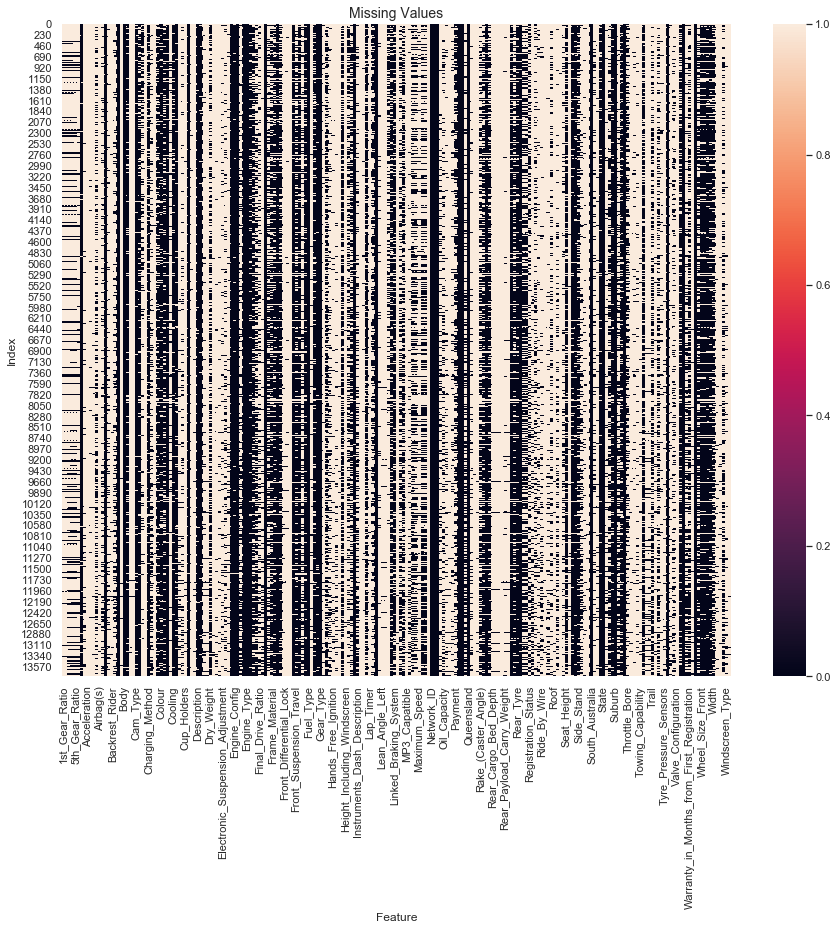

In [251]:
# Display missing values as a heatmap, where the hot part represents missing data
def missing_heatmap(df):
    fig, ax = plt.subplots(figsize=(15,12))
    sns.heatmap(df.isnull(), cbar=True, ax=ax)
    plt.xlabel('Feature')
    plt.ylabel('Index')
    plt.title('Missing Values', fontsize=14)
    plt.show()

missing_heatmap(df)
# The pale region indicates missing values.

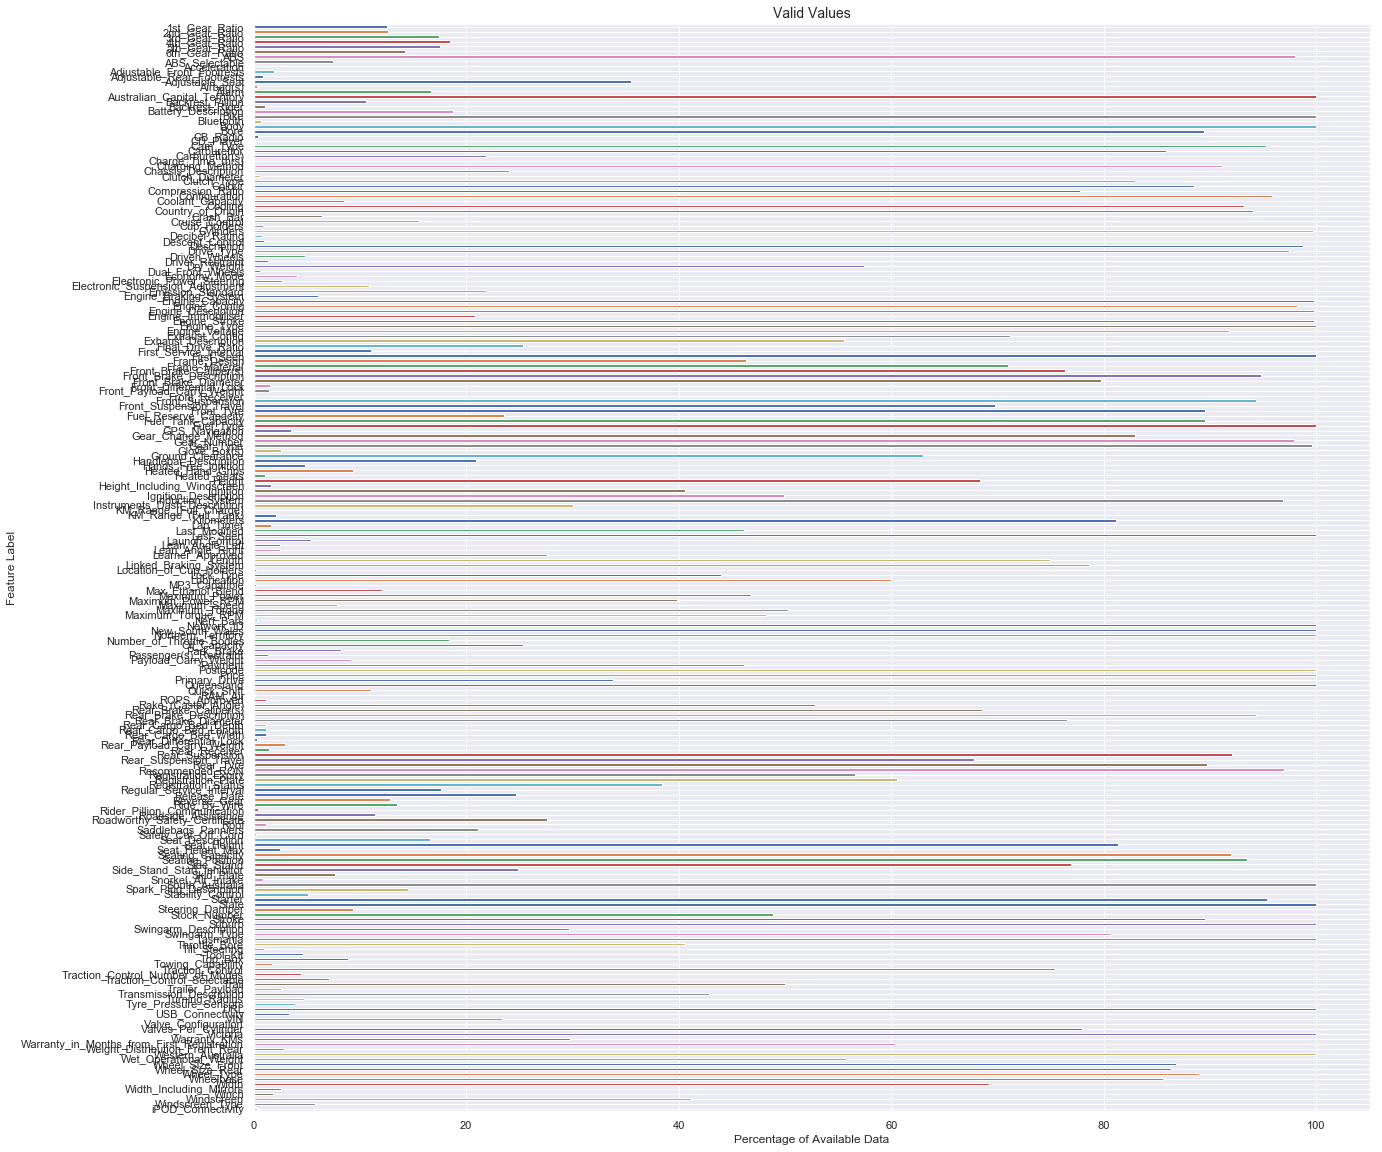

57.759% of data is missing 


In [252]:
# Alternatively display number of valid data as a percentage in a bar chart
def missing_bar(df):
    total = df.shape[0]
    missing = (total - df.isnull().sum())/total * 100
    missing.plot(kind='barh',figsize=(20,20))
    plt.gca().invert_yaxis()
    plt.xlabel('Percentage of Available Data')
    plt.ylabel('Feature Label')
    plt.title('Valid Values', fontsize=14)
    plt.show()

    print('{}% of data is missing '.format(round(df.isnull().sum().sum()/float(df.size)*100,3)))
    
missing_bar(df)


#### Dealing with Missing Values
We currently only have ~40% of the potential data that could be available. This would need to be improved if we want to be able to make any predictions on the data. We can accomplish this a number of ways;

1. We can increase this by removing some of the features that have more than 80-90 % of missing data. Imputing data for the missing values in this case will not add any usefullness to the data.

2. We can then look at the features that dont provide any variation, ie. only 1 unique value. 




In [253]:
# Remove all features that have less than 10%  of data.

def remove_columns(df, null_threshold=0.9):
    minimum_null_threshold = null_threshold * df.shape[0]
    remove_list = []

    for col in list(df.columns):
        if (df[col].isnull().sum() > minimum_null_threshold):
            remove_list.append(col)
            print (col,df[col].isnull().sum()/df.shape[0])

    print ('Columns before: ',len(df.columns))
    df.drop(remove_list,axis=1, inplace=True)
    print ('Columns after: ',len(df.columns))

    return df
    

In [254]:
df = remove_columns(df, null_threshold=0.8)
print('{}% of data is missing '.format(round(df.isnull().sum().sum()/float(df.size)*100,3)))


1st_Gear_Ratio 0.8741284137129576
2nd_Gear_Ratio 0.8732568274259151
3rd_Gear_Ratio 0.8259006391632772
4th_Gear_Ratio 0.8152963393375944
5th_Gear_Ratio 0.8248111563044741
6th_Gear_Ratio 0.857931435212086
ABS_Selectable 0.9252614758861127
Acceleration 0.9992736780941314
Adjustable_Front_Footrests 0.9805345729227194
Adjustable_Rear_Footrests 0.9907030796048809
Airbag(s) 0.997239976757699
Alarm 0.8333817547937246
Backrest_Pillion 0.8943201626961069
Backrest_Rider 0.9893230679837304
Battery_Description 0.812754212667054
Bluetooth 0.9929546775130738
CB_Radio 0.996150493898896
CD_Player 0.9982568274259151
Charge_Time_(hrs) 0.9994915746658919
Clutch_Diameter 0.99397152818129
Coolant_Capacity 0.9150929692039512
Crash_Bar 0.9352120859965136
Cruise_Control 0.844203951191168
Cup_Holders 0.9912115049389889
Decibel_Rating 0.992300987797792
Descent_Control 0.9904851830331203
Driven_Wheels 0.951554328878559
Driver_Restraint 0.9860546194073213
Dual_Front_Wheels 0.9941167925624637
Economy_Mode 0.9588901

In [255]:
#df = remove_columns(df, null_threshold=0.8)


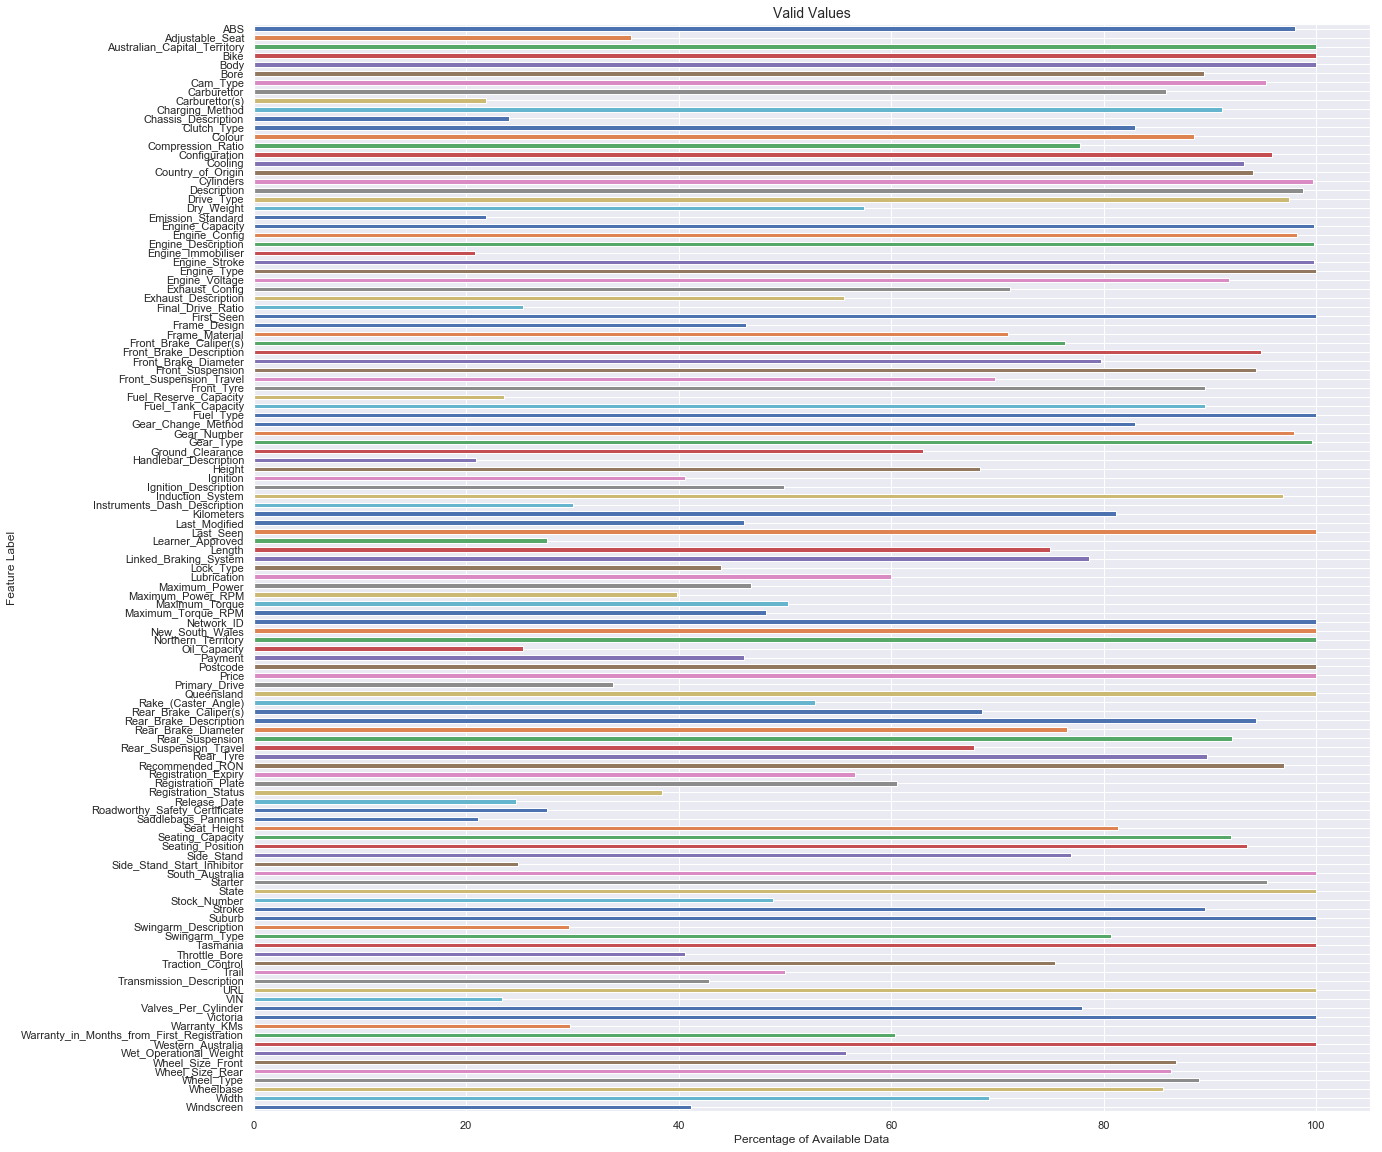

28.159% of data is missing 


In [256]:
missing_bar(df)


Australian_Capital_Territory 0.0
New_South_Wales 0.0
Northern_Territory 0.0
Queensland 0.0
South_Australia 0.0
Tasmania 0.0
Victoria 0.0
Western_Australia 0.0
Columns before:  121
Columns after:  113


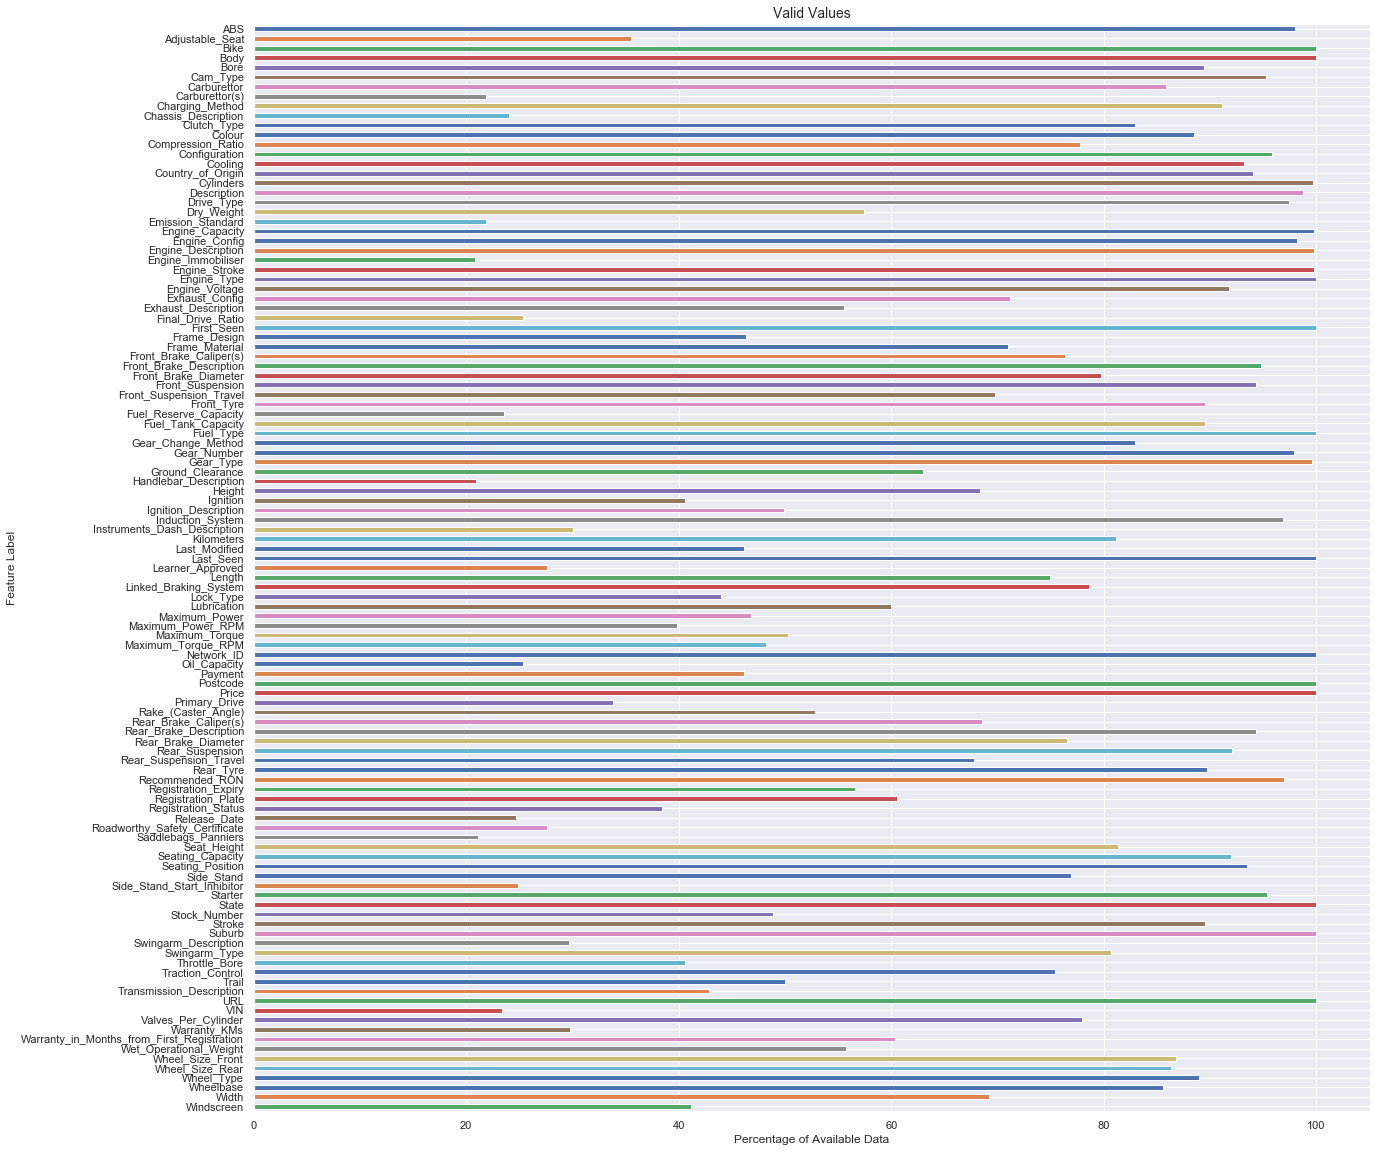

30.152% of data is missing 


In [257]:
remove_list = []

for col in list(df.columns):
    if ((len(df[col].unique()) == 1) & (col != 'Last_Seen')):
        remove_list.append(col)
        print (col,df[col].isnull().sum()/df.shape[0])

print ('Columns before: ',len(df.columns))
df.drop(remove_list,axis=1, inplace=True)
print ('Columns after: ',len(df.columns))
    
    
missing_bar(df)


### Imputing missing values
We can use our domain knowledge to impute missing vales. Some missing values we can assume that they are missing because they dont exist for the specified bike, others we will determine using the frequency of existing values or find commoon values for similar bikes. These will depend on the feature in question.

In [260]:
# We will repalce the missing values in these features with 'No' for not 
# relevant or isn't included in/on the bike.
df['ABS'][df['ABS'].isnull() == True] = 'No'
df['Adjustable_Seat'][df['Adjustable_Seat'].isnull() == True] = 'No'
df['Engine_Immobiliser'][df['Engine_Immobiliser'].isnull() == True] = 'No'
df['Learner_Approved'][df['Learner_Approved'].isnull() == True] = 'No'
df['Linked_Braking_System'][df['Linked_Braking_System'].isnull() == True] = 'No'
df['Warranty_KMs'][df['Warranty_KMs'].isnull() == True] = 'No'
#df['Reverse_Gear'][df['Reverse_Gear'].isnull() == True] = 'No'
df['Roadworthy_Safety_Certificate'][df['Roadworthy_Safety_Certificate'].isnull() == True] = 'No'
df['Saddlebags_Panniers'][df['Saddlebags_Panniers'].isnull() == True] = 'No'
df['Warranty_in_Months_from_First_Registration'] \
    [df['Warranty_in_Months_from_First_Registration'].isnull() == True] = 'No Warranty'




In [261]:
df['Colour'][df['Colour'].isnull() == True] = 'Not Specified'
df['Description'][df['Description'].isnull() == True] = 'No Description'

df['Cylinders'][df['Cylinders'].isnull() == True] = int(df['Cylinders'].mode())
df['Engine_Stroke'][df['Engine_Stroke'].isnull() == True] = int(df['Engine_Stroke'].mode())
df['Engine_Type'][df['Engine_Type'].isnull() == True] = df['Engine_Type'].mode()
df['Engine_Voltage'][df['Engine_Voltage'].isnull() == True] = df['Engine_Voltage'].mode()
df['Fuel_Type'][df['Fuel_Type'].isnull() == True] = df['Fuel_Type'].mode()
df['Gear_Change_Method'][df['Gear_Change_Method'].isnull() == True] = df['Gear_Change_Method'].mode()
df['Gear_Number'][df['Gear_Number'].isnull() == True] = int(df['Gear_Number'].mode())
df['Gear_Type'][df['Gear_Type'].isnull() == True] = df['Gear_Type'].mode()
df['Induction_System'][df['Induction_System'].isnull() == True] = df['Induction_System'].mode()
df['Lock_Type'][df['Lock_Type'].isnull() == True] = df['Lock_Type'].mode()
df['Rear_Brake_Caliper(s)'][df['Rear_Brake_Caliper(s)'].isnull() == True] = df['Rear_Brake_Caliper(s)'].mode()
df['Recommended_RON'][df['Recommended_RON'].isnull() == True] = df['Recommended_RON'].mode()
df['Side_Stand'][df['Side_Stand'].isnull() == True] = df['Side_Stand'].mode()
df['Swingarm_Type'][df['Swingarm_Type'].isnull() == True] = df['Swingarm_Type'].mode()
df['Registration_Status'][df['Registration_Status'].isnull() == True] = df['Registration_Status'].mode()





In [262]:
manual_drop = ['Emission_Standard','Instruments_Dash_Description','Payment','Registration_Status']

df.drop(manual_drop, axis=1, inplace=True)


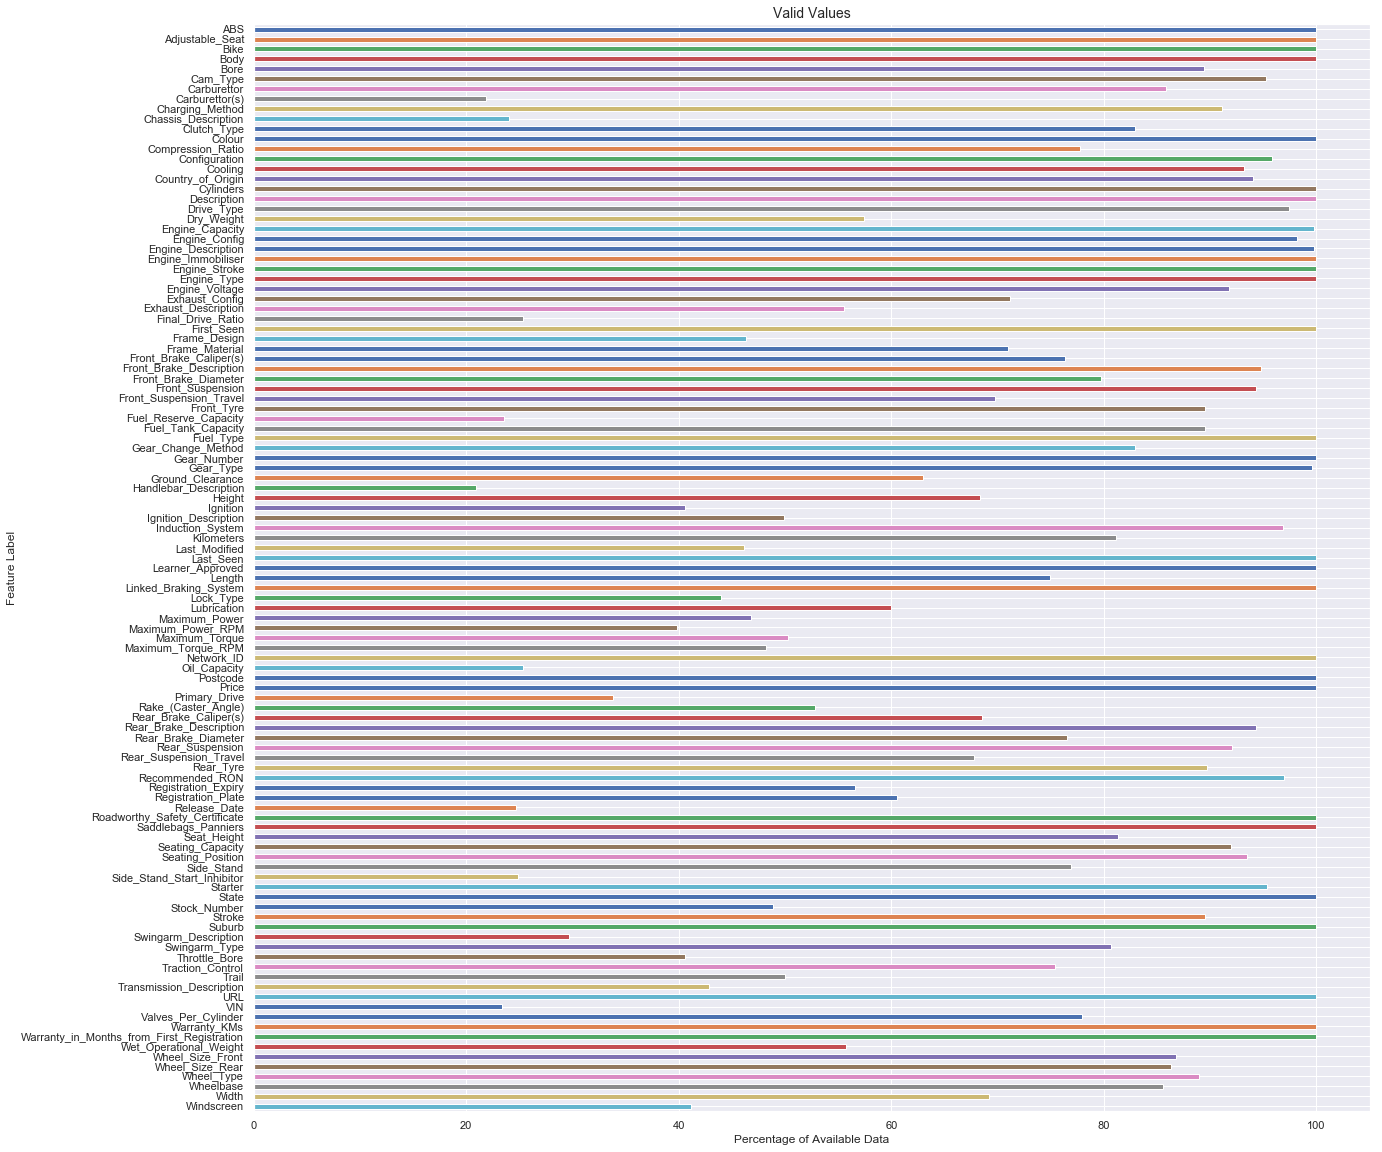

24.107% of data is missing 


In [263]:
missing_bar(df)


In [264]:
sorted(list(df['Carburettor'].unique())[1:])

['"Slingshot"',
 '1',
 '20mm',
 '21mm',
 '22',
 '24',
 '26',
 '27',
 '28mm Keihin Carburettor',
 '28mm Mikuni downdraft-type',
 '30',
 '32',
 '34',
 '37 mikuni',
 '38',
 '39',
 '40',
 '48',
 'Amac',
 'Amal',
 'Amal (Twin carbs optional extra)',
 'Amal 376/35',
 'Amal 930; Concentric',
 'Amal 932',
 'Amal Concentric',
 'Amal MK1',
 'Amal MkI',
 'Amal Monobloc',
 'Amal Monobloc 375',
 'Amal Monobloc 376',
 'Amal Monobloc 626',
 'Amal R930',
 'Amal concentric 626',
 'Atomik',
 'BDS28',
 'BSR37',
 'BSR40',
 'Batteryless Fuel Injection, Keihin throttle body',
 'Bendix',
 'Bing',
 'Bing; Constant depression Type',
 'Bing; Constant depression Type, 64/32/11 - 64/32/12',
 'Bing; Constant depression Type, 94/40/105 - 94/40/106',
 'Bing; Constant depression type',
 'Bing; Constant velocity',
 'CV',
 'CV (Constant Velocity)',
 'CV (Constant Velocity) Double float',
 'CV (Constant Velocity), Enricher/choke & accelerator pump',
 'CV (Constant Velocity), Enricher/choke & accelerator pump1',
 'CV (Co

In [265]:
df['Carburettor'][df['Carburettor'].isnull() == True] = 'none'

df['Carburettor'][df['Carburettor'].str.contains('Amal')] = 'Amal'
df['Carburettor'][df['Carburettor'].str.contains('Bing')] = 'Bing'
df['Carburettor'][df['Carburettor'].str.contains('CV')] = 'Constant Velocity'
df['Carburettor'][df['Carburettor'].str.contains('Constant Velocity')] = 'Constant Velocity'
df['Carburettor'][df['Carburettor'].str.contains('Carb')] = 'Carburettor'
df['Carburettor'][df['Carburettor'].str.contains('DDFI')] = 'Down Draft Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('DEFI')] = 'Digital Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('DFI ')] = 'Digital Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('DFSI')] = 'Dual Stage Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Dell')] = 'DellOrto'
df['Carburettor'][df['Carburettor'].str.contains('MEFI')] = 'MultiPoint Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('MPSEFI')] = 'MultiPoint Sequential Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('MSEFI')] = 'MultiPoint Sequential Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('PGM-EFI')] = 'Programmed Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Multi-point EFI')] = 'MultiPoint Sequential Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('EFI')] = 'Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('EIPI')] = 'Electronic Intake Pipe Injection'
df['Carburettor'][df['Carburettor'].str.contains('Keihin')] = 'Keihin'
df['Carburettor'][df['Carburettor'].str.contains('MPEI')] = 'MultiPoint Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Teikei')] = 'Teikei'
df['Carburettor'][df['Carburettor'].str.contains('EI')] = 'Electronic Injection'
df['Carburettor'][df['Carburettor'].str.contains('ESPFI')] = 'Electronic Sequential Port Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('FCR MX37')] = 'FCR MX37'
df['Carburettor'][df['Carburettor'].str.contains('Flat')] = 'Flatslide'
df['Carburettor'][df['Carburettor'].str.contains('FI')] = 'Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('PFI')] = 'Port Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('PGM-DSFI')] = 'Programmed Dual Sequential Fuel Injection system'
df['Carburettor'][df['Carburettor'].str.contains('PGM-FI')] = 'Programmed Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('SFI ')] = 'MultiPoint Sequential Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('YFI')] = 'Yamaha Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Fuel Injected')] = 'Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Mikumi')] = 'Mikumi'
df['Carburettor'][df['Carburettor'].str.contains('Mikuni')] = 'Mikuni'
df['Carburettor'][df['Carburettor'].str.contains('Multipoint sequential electronic fuel injection')] = 'MultiPoint Sequential Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Multipoint sequential electronic injection')] = 'MultiPoint Sequential Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Nikki')] = 'Nikki'
df['Carburettor'][df['Carburettor'].str.contains('PGM')] = 'Programmed Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('Piston ')] = 'Piston Valve Type'
df['Carburettor'][df['Carburettor'].str.contains('TPI ')] = 'Transfer Port Injection'
df['Carburettor'][df['Carburettor'].str.contains('PI')] = 'Port Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('PZ')] = 'PZ'
df['Carburettor'][df['Carburettor'].str.contains('Programmed')] = 'Programmed Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('SDTV')] = 'Suzuki Dual Throttle Valve fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('TCBI')] = 'Digital Electronic Fuel Injection'
df['Carburettor'][df['Carburettor'].str.contains('TPS')] = 'Throttle position sensor'


In [267]:
sorted(list(df_copy['Carburettor'].unique()))

801

In [53]:
# Impute using random forest 

['Bore','Cam_Type','Carburettor','Charging_Method','Clutch_Type','Cooling',
 'Country_of_Origin','Dry_Weight', 'Front_Brake_Caliper(s)','Seating_Position']


In [240]:
words = ['Slingshot',
 '1',
 '20mm',
 '21mm',
 '22',
 '24',
 '26',
 '27',
 '28mm Keihin Carburettor',
 '28mm Mikuni downdraft-type',
 '30',
 '32',
 '34',
 '37 mikuni',
 '38',
 '39',
 '40',
 '48',
 'Amac',
 'Amal',
 'Amal (Twin carbs optional extra)',
 'Amal 376/35',
 'Amal 930; Concentric',
 'Amal 932',
 'Amal Concentric',
 'Amal MK1',
 'Amal MkI',
 'Amal Monobloc',
 'Amal Monobloc 375',
 'Amal Monobloc 376',
 'Amal Monobloc 626',
 'Amal R930',
 'Amal concentric 626',
 'Atomik',
 'BDS28',
 'BSR37',
 'BSR40',
 'Batteryless Fuel Injection, Keihin throttle body',
 'Bendix',
 'Bing',
 'Bing; Constant depression Type',
 'Bing; Constant depression Type, 64/32/11 - 64/32/12',
 'Bing; Constant depression Type, 94/40/105 - 94/40/106',
 'Bing; Constant depression type',
 'Bing; Constant velocity',
 'CV',
 'CV (Constant Velocity)',
 'CV (Constant Velocity) Double float',
 'CV (Constant Velocity), Enricher/choke & accelerator pump',
 'CV (Constant Velocity), Enricher/choke & accelerator pump1',
 'CV (Constant Velocity), Slanted flat-side',
 'CV (Constant Velocity); Secondary accelerator pump',
 'CV (Constant Velocity); Slanted flat-slide',
 'CV (Constant velocity)',
 'CV Type',
 'CV, Flatslide',
 'Carb or EFI',
 'Carburettor Keihin# FCR39 Flatslide',
 'Carburettor Keihin; FCR39 Flatslide',
 'Carburettor Mikuni BSR34SS',
 'Carburettor Mikuni BSR36',
 'Carburettor Mikuni BSR36 CV-type',
 'Carburettor Mikuni# BSR36 CV-type',
 'Carburettor or EFI',
 'DDFI - Down Draft Fuel Injection',
 'DDFI III Electronic Fuel Injection',
 'DDFI III- Downdraft digital fuel injection',
 'DEFI - Digital Electronic Fuel Injection; Magnetti Marelli; RbW',
 'DEFI - Digital Electronic Fuel Injection; Mikuni',
 'DEFI - Digital Electronic Fuel Injection; Mikuni; 12-hole injectors',
 'DEFI - Digital Electronic Fuel Injection; Synerject',
 'DEFI - Digital Electronic Fuel Injection; Synerjet',
 'DEI - Dual Electronic Injection; Synerject',
 'DFI - Digital Fuel Injection',
 'DFI - Digital Fuel Injection (SDTV)',
 'DFI - Digital Fuel Injection - Keihin; 3-map choices; Batteryless (Optional extra KX FI Calibration kit)',
 'DFI - Digital Fuel Injection, Keihin',
 'DFI - Digital Fuel Injection, Keihin oval sub-throttles, Dual injection',
 'DFI - Digital Fuel Injection, Keihin oval sub-throttles, dual injection',
 'DFI - Digital Fuel Injection, Keihin throttle bodies',
 'DFI - Digital Fuel Injection, Keihin, Oval sub throttles',
 'DFI - Digital Fuel Injection, Keihin, Oval sub throttles, 2 injectors per throttle body',
 'DFI - Digital Fuel Injection, Mikuni',
 'DFI - Digital Fuel Injection, Mikuni throttle bodies',
 'DFI - Digital Fuel Injection; 2 x sub throttles',
 'DFI - Digital Fuel Injection; 4 x subthrottles',
 'DFI - Digital Fuel Injection; Denso 12-hole injectors; Keihin; Oval Sub-throttles',
 'DFI - Digital Fuel Injection; Dual throttle valves',
 'DFI - Digital Fuel Injection; Keihin',
 'DFI - Digital Fuel Injection; Keihin throttle bodies',
 'DFI - Digital Fuel Injection; Keihin, Oval sub-throttles, Dual injectors',
 'DFI - Digital Fuel Injection; Keihin; 12-hole',
 'DFI - Digital Fuel Injection; Keihin; 12-hole (Batteryless)',
 'DFI - Digital Fuel Injection; Keihin; 4 x subthrottles',
 'DFI - Digital Fuel Injection; Keihin; Dual injectors',
 'DFI - Digital Fuel Injection; Keihin; Dual throttle valves',
 'DFI - Digital Fuel Injection; Keihon; Dual throttle valves',
 'DFI - Digital Fuel Injection; Oval Sub-throttles',
 'DFI - Digital Fuel Injection; Oval sub-throtles',
 'DFI - Digital Fuel Injection; SDTV (Suzuki Dual Throttle Valve)',
 'DFI - Digital Fuel Injection; Synerject',
 'DFI - Digital Fuel Injection; YCC-T (Yamaha Chip controlled throttle); YCC-I; 12-hole main injectors',
 'DFI - Electronic Fuel Injection, Keihin, Dual injection, Oval sub-throttles',
 'DFI Digital Fuel Injection; Suzuki dual throttle valve (SDTV)',
 'DFI with Keihin Throttle Bodies',
 'DFI, Keihin throttle bodies',
 'DFSI - Dual Stage Fuel Injection; 2 x 12-hole injectors per cylinder']

import difflib

difflib.get_close_matches('Amal', words, n=30, cutoff=0.3)

['Amal',
 'Amac',
 'Amal MkI',
 'Amal MK1',
 'Amal 932',
 'Amal R930',
 'Amal 376/35',
 'Amal Monobloc',
 'Amal Concentric',
 'Atomik',
 'Amal Monobloc 626',
 'Amal Monobloc 376',
 'Amal Monobloc 375',
 'Amal concentric 626',
 'Amal 930; Concentric']

In [241]:
difflib.get_close_matches('Bing', words, n=30, cutoff=0.2)

['Bing',
 'Slingshot',
 'Bendix',
 '37 mikuni',
 'Bing; Constant velocity',
 'Bing; Constant depression type',
 'Bing; Constant depression Type',
 'BSR40',
 'BSR37',
 'BDS28',
 'Atomik']

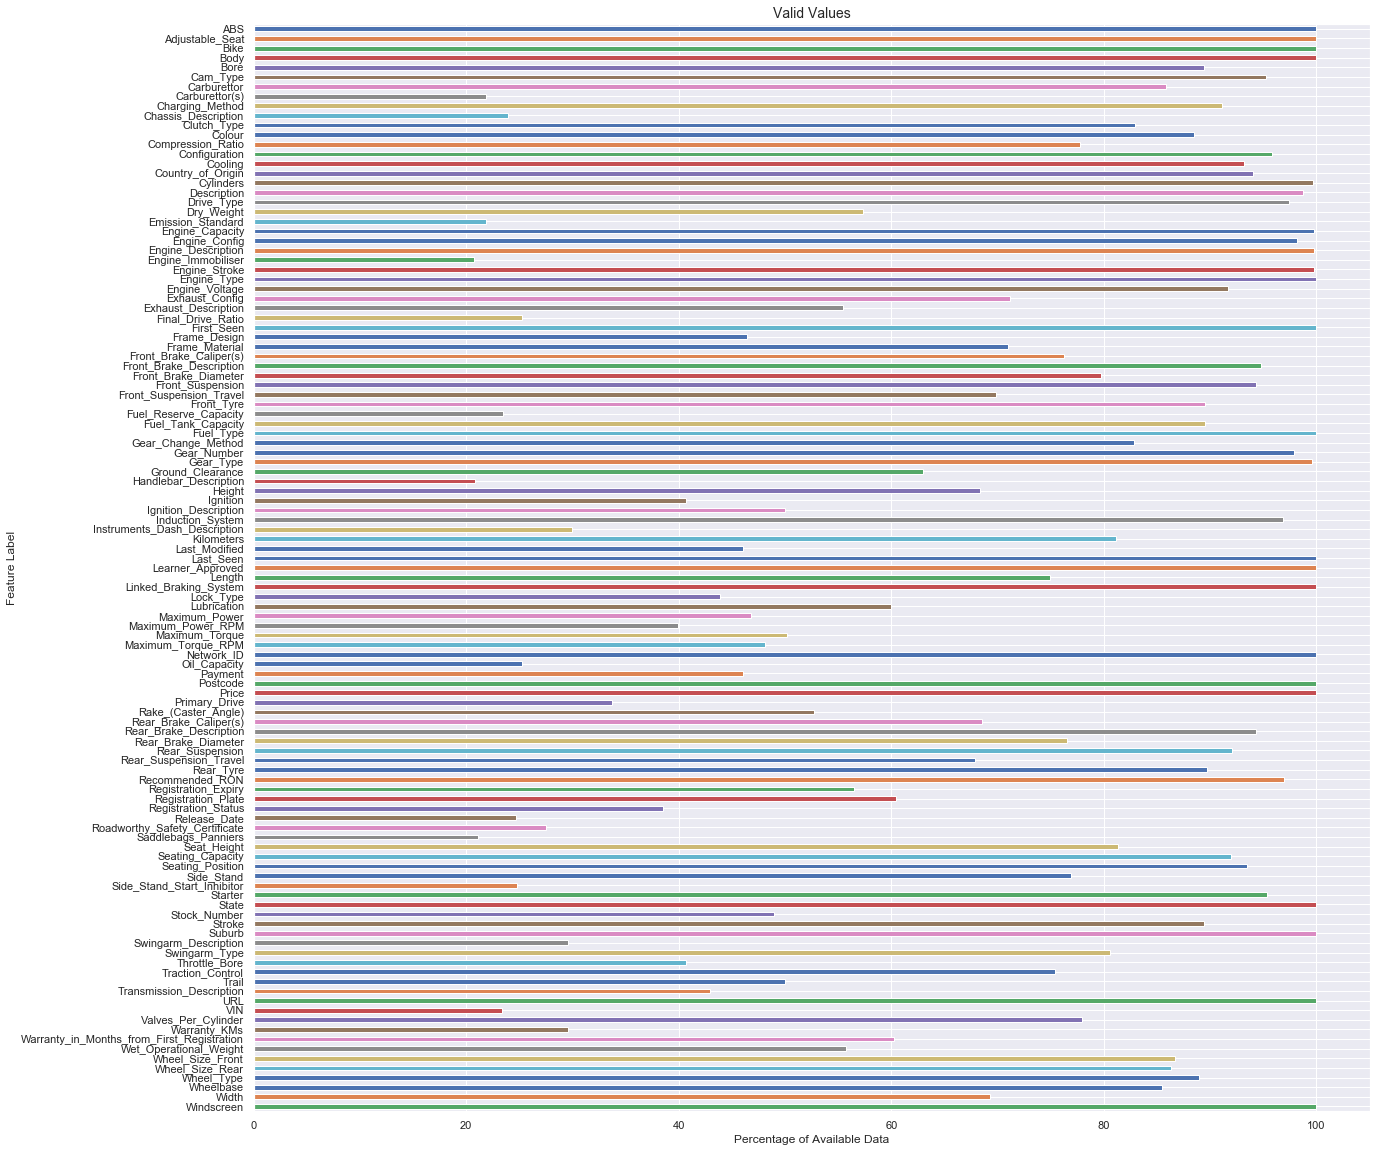

28.234% of data is missing 


In [37]:
missing_bar(df)


1st_Gear_Ratio - remove
2nd_Gear_Ratio - remove
3rd_Gear_Ratio - remove
4th_Gear_Ratio - remove
5th_Gear_Ratio - remove
6th_Gear_Ratio - remove
ABS_Selectable - impute (mode)
Acceleration - 
Adjustable_Front_Footrests - impute (mode)
Airbag(s) - impute (mode)
Alarm - impute (mode)
Backrest_Pillion - impute (mode)
Backrest_Rider - impute (mode)
Battery_Description - 
Bluetooth - impute (mode)
CD_Player - impute (mode)
Charge_Time_(hrs) - 
Chassis_Description - 
Clutch_Diameter
Coolant_Capacity - impute (mode/mean)
Crash_Bar - impute (mode)
Cruise_Control - impute (mode)
Cup_Holders - impute (mode)
Decibel_Rating
Descent_Control - impute (mode)
Driven_Wheels
Driver_Restraint - impute (mode) or 0
Dual_Front_Wheels
Economy_Mode - impute (mode) or No
Electronic_Power_Steering
Electronic_Suspension_Adjustment
Emission_Standard
Engine_Braking_System
Engine_Immobiliser - impute (mode)
First_Service_Interval
Front_Differential_Lock - impute (mode) or No
Front_Payload_Carry_Weight - impute (0)
Front_Receiver
Fuel_Reserve_Capacity - impute (mode)
GPS_Navigation
Glove_Box(s)
Handlebar_Description
Hands_Free_Ignition - impute (random forest) - find similar model bike
Heated_Hand_Grips
Heated_Seats - impute (mode) or No
Height_Including_Windscreen
Instruments_Dash_Description
KM_Range_(Full_Charge)
KM_Range_(Full_Tank)
Launch_Control
MP3_Capatible - impute (mode) or No
Max_Ethanol_Blend - impute (mode) or 10%
Maximum_Speed
Nerf_Bars
Number_of_Throttle_Bodies - impute (random forest)
Oil_Capacity - impute (mode)
Park_Brake - impute (mode) or No
Passenger(s)_Restraint - impute (mode) or No
Payload_Carry_Weight - impute (0)
Primary_Drive
Quick_Shift
ROPS_Approved
Rear_Cargo_Bed_Depth - impute (0)
Rear_Cargo_Bed_Length - impute (0)
Rear_Cargo_Bed_Width - impute (0)
Rear_Differential_Lock
Rear_Payload_Carry_Weight - impute (0)
Rear_Receiver
Regular_Service_Interval
Reverse_Gear - impute (mode) or No
Ride_By_Wire
Rider_Pillion_Communication - impute (mode) or No
Roadside_Assistance
Roof - impute (mode) or No
Saddlebags_Panniers - impute (mode) or No
Safety_Cut_Off_Cord
Seat_Description
Seat_Height_Max
Side_Stand_Start_Inhibitor
Skid_Plate
Snorkel_Air_Intake - impute (mode) or No
Spark_Plug_Description
Stability_Control
Steering_Damper
Swingarm_Description
Tilt_Steering
Tool_Kit
Top_Box
Towing_Capability
Traction_Control_Selectable
Trailer_Payload
Turning_Radius
Tyre_Pressure_Sensors
USB_Connectivity
VIN
Valve_Configuration
Warranty_KMs
Weight_Distribution_Front_Rear
Width_Including_Mirrors
Winch - impute (mode) or No
Windscreen_Type

In [17]:
df.head()


,ABS,Adjustable_Seat,Bike,Body,Bore,Cam_Type,Carburettor,Carburettor(s),Charging_Method,Chassis_Description,...,Valves_Per_Cylinder,Warranty_KMs,Warranty_in_Months_from_First_Registration,Wet_Operational_Weight,Wheel_Size_Front,Wheel_Size_Rear,Wheel_Type,Wheelbase,Width,Windscreen
0,No,No,Kuda Pro 250,Adventure Touring,62.0 mm,SOHC (Single Over Head Cam),NaN,1.0,NaN,NaN,...,NaN,NaN,3 Months - Parts Only,150.00 kg,"1.60x21""","1.85x18""","Chrome rim, Heavy duty Spokes, Alloy Hub",1480 mm,860 mm,No
1,No,No,250 R Road Manual 5sp 250cc (Discontinued),Super Sport,77.0 mm,SOHC (Single Over Head Cam),NaN,1.0,Engine,NaN,...,4.0,NaN,NaN,136.00 kg,"2.75x17""","3.5x17""","Black, T9 Aluminium rims, 5-star spoke",1350 mm,NaN,Standard
2,No,No,GN250 (Jan),Naked,72.0 mm,SOHC (Single Over Head Cam),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,No,No,GSX1100 ESD Road Manual 5sp 1100cc (Half fairing),Sport Touring,NaN,DOHC (Double Over Head Cam),CV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,No,No,TS250 Trail Manual 5sp 250cc,Trail,NaN,Reed Valve,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
